In [79]:
import numpy as np
import pandas as pd
from numpy.random import randn
np.random.seed(101)
DATA_DIR = '/Users/nathanzhao/Desktop/Python_quant_finance' + \
        '/Python-for-Finance-Repo-master-master' + \
        '/08-Time-Series-Analysis' 
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression

%matplotlib inline

# Catalog
1. Make sure all features stationary
2. Use weighted regression!!!!

### Funcs

In [63]:
def BINPLOT_VA1_parted_eq_by_VA2(
        df, 
        num_q, 
        va1, 
        va2, 
        va2_is_index = False, 

        apply_float_precision = True,
        precision_float = 2,
    
        whether_plot = True,
        fig_size = (16,4),
        show_x_ticks = True
    ): 
    """
    Params:
        【va2_is_index】 True:
                Then 【va2】 is just a name of x axis
        【apply_float_precision】 True: 
                Only when 【va2】 is float/int
    Returns: 
        DataFrame of means, stds & counts
    Note:
        1. Require no repeating index, for time series index, 
            consider push repeating index by 1ns, repeat 
            until no repetition left.
    """
    
    # groupby / partition
    if va2_is_index:
        unstacked = df[va1].groupby(pd.qcut(df.index, q = num_q)).apply(pd.DataFrame)
    else:
        unstacked = df[va1].groupby(pd.qcut(df[va2], q = num_q)).apply(pd.DataFrame)
    precision_str = "{:." + str(precision_float) + "f}"
    if apply_float_precision:
        columns_interval_left = list(map(lambda x : precision_str.format(x.left), list(unstacked.columns)))
    else :
        columns_interval_left = list(map(lambda x : x.left, list(unstacked.columns)))
        
    # plot
    if whether_plot:
        ax = pd.DataFrame(unstacked.values).plot(kind='box',figsize = fig_size)
        if show_x_ticks:
            _ = ax.set_xticklabels(columns_interval_left)
        _ = ax.set_xlabel("LEFT of {" + va2 + "}")
        _ = ax.set_ylabel(va1)
    
    # return
    ls_means = list(unstacked.mean(axis = 0, skipna = True))
    ls_stds = list(unstacked.std(axis = 0, skipna = True))
    ls_counts =list((-1*(unstacked.isna()-1)).sum())
    df_ret = pd.DataFrame(data = ([ls_means, ls_stds,ls_counts]),
                          index = ['mean','std','count'],
                          columns = columns_interval_left)
    df_ret = df_ret.transpose()
    df_ret.rename_axis("LEFT of {" + va2 + "}", inplace = True)
    return df_ret

In [84]:
def R_Square(y_pred, y_true):
    y_mean = y_true.mean()
    SS_res = ((y_pred - y_true) ** 2).sum()
    SS_tot = ((y_true - y_mean) ** 2).sum()
    return 1 - SS_res / SS_tot

### Prepare df

In [98]:
df = pd.read_csv('data.csv')
df.set_index ('timestamp', inplace = True)
df['diff_10_y'] = (df['yprice'].shift(10) - df['yprice'])
df['diff_20_y']= (df['yprice'].shift(20) - df['yprice'])
df['diff_40_y'] = (df['yprice'].shift(40) - df['yprice'])
df.dropna(inplace = True)
df['diff_10_x'] = (df['xprice'].shift(10) - df['xprice'])
df['diff_20_x']= (df['xprice'].shift(20) - df['xprice'])
df['diff_40_x'] = (df['xprice'].shift(40) - df['xprice'])
df.dropna(inplace = True)
df['x_y_diff_ratio'] = df['diff_10_y'] / (df['diff_10_x'] + 0.0000001)

### Collect std rolling, then shift forward

In [99]:
df['roll_std'] = df['returns'].rolling(window = 31).std().shift(15)
df.dropna(inplace = True)
df['abs_returns'] = abs(df['returns'])

,mean,std,count
LEFT of {roll_std},,,
-0.00,0.063189,0.069939,68501.0
0.03,0.086116,0.079110,68501.0
0.04,0.107398,0.095510,68501.0
0.06,0.132169,0.115103,68501.0
0.08,0.201560,0.169649,68501.0


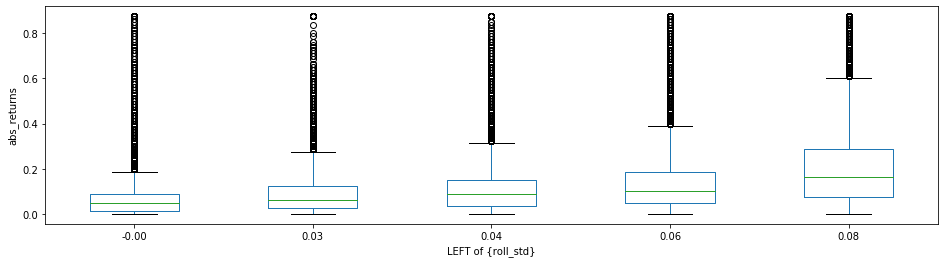

In [100]:
BINPLOT_VA1_parted_eq_by_VA2(
        df = df, 
        num_q = 5, 
        va1 = 'abs_returns', 
        va2 = 'roll_std', 
        va2_is_index = False, 

        apply_float_precision = True,
        precision_float = 2,
    
        whether_plot = True,
        fig_size = (16,4),
        show_x_ticks = True
    )

### Train Test Split

In [101]:
train_df = df.iloc[:200000]
test_df = df.iloc[-100000:]
train_df = train_df.iloc[:160000]
valid_df = train_df.iloc[-40000:]

In [102]:
train_df.shape

(160000, 12)

# Regression

In [103]:
INDEX = [
    'diff_10_x',
    'diff_20_x', 
    'diff_40_x',
    'diff_10_y', 
    'diff_20_y', 
    'diff_40_y',
    'x_y_diff_ratio'
]

X       = train_df [INDEX]
y       = train_df ['returns']
X_valid = valid_df [INDEX]
y_valid = valid_df ['returns']
X_test  = test_df  [INDEX]
y_test  = test_df  ['returns']


In [104]:
reg = LinearRegression()

In [120]:
def run_reg(algo):
    algo.fit(X, y, 1/(train_df['roll_std']+1) )
    algo.fit(X,y)
    print(R_Square(algo.predict(X), y))
    print(R_Square(algo.predict(X_valid), y_valid))
#     print(R_Square(algo.predict(X_test), y_test))
run_reg(reg)

0.003252866646619945
-0.00043592366573941277
